In [1]:
from __future__ import division
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

NUM_BINS = 10
VAR = 0.01 # takes value from (0, 0.25)

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
data = np.genfromtxt("cifar100_predictions_dropout.txt")# 10000*101
probabilities = data[:,1:]
confidence = np.max(probabilities, axis=1)
Y_predict = np.argmax(probabilities, axis=1)
Y_true = data[:,0]

bins = np.linspace(0, 1, NUM_BINS+1)
digitized = np.digitize(confidence, bins)-1

print(confidence.mean())
print (Y_predict == Y_true).mean()

0.840096000974
0.7414


**Choose prior for each bin**

For each bin of reliability diagram, the prior distribution is a Beta distribution

In [3]:
def BetaParams(mu, var):
    """
    Compute parameters of Beta distribution given mean and variance.
    """
    alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
    beta = alpha * (1 / mu - 1)
    return alpha, beta

In [4]:
BetaPriors = np.array([BetaParams((i+0.5)/NUM_BINS,VAR) for i in range(NUM_BINS)])
Counts = np.array([(((Y_predict[digitized==i])==(Y_true[digitized==i])).sum(),
           ((Y_predict[digitized==i])!=(Y_true[digitized==i])).sum())
          for i in range(NUM_BINS)])
BetaPosteriors = BetaPriors + Counts

In [5]:
BetaPosteriorsMean = np.array([BetaPosteriors[i,0]/(BetaPosteriors[i].sum()) 
                               for i in range(NUM_BINS)])
BetaPosteriorP025 = np.array([stats.beta.ppf(0.025,BetaPosteriors[i,0], BetaPosteriors[i,1]) 
                                 for i in range(NUM_BINS)])
BetaPosteriorP975 = np.array([stats.beta.ppf(0.975,BetaPosteriors[i,0], BetaPosteriors[i,1]) 
                                 for i in range(NUM_BINS)])

In [6]:
confidence_bins = [confidence[digitized==i].mean() for i in range(NUM_BINS)]
accuracy_bins = [(Y_predict[digitized==i]==Y_true[digitized==i]).mean() 
                                              for i in range(NUM_BINS)]

/home/disij/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/home/disij/.local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/disij/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()


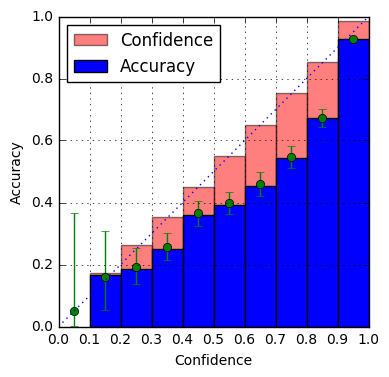

In [7]:
plt.figure(figsize=(4,4))
plt.grid(True)
plt.xticks(range(NUM_BINS+1), ["%.1f" % i for  i in bins])
plt.bar(range(NUM_BINS),confidence_bins,color='r',width=1.0,label="Confidence",alpha=0.5)
plt.bar(range(NUM_BINS),accuracy_bins,color='b',width=1.0,label="Accuracy")
plt.errorbar([i+0.5 for i in range(NUM_BINS)],
             BetaPosteriorsMean,
             yerr=(BetaPosteriorsMean-BetaPosteriorP025,BetaPosteriorP975-BetaPosteriorsMean),
             fmt='o', color = 'g')
plt.plot(np.linspace(0, 1, 11),linestyle=":")
plt.legend(loc='upper left')
plt.xlabel("Confidence")
plt.ylabel("Accuracy")